In [1]:

from datasets import load_dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torchvision import transforms
import torch
import numpy as np

beans_data = load_dataset("beans")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")


/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Resize to ViT input size
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])
def preprocess_data_with_torchvision(examples, transform):
    processed_images = []
    for image in examples["image"]:
        # Apply the given transform
        processed_image = transform(image)
        processed_images.append(processed_image.numpy())
    examples["pixel_values"] = processed_images
    return examples



In [3]:
# Apply data augmentation to train, and regular preprocessing to validation/test
beans_data["train"] = beans_data["train"].map(
    lambda examples: preprocess_data_with_torchvision(examples, train_transform), batched=True
)
beans_data["validation"] = beans_data["validation"].map(
    lambda examples: preprocess_data_with_torchvision(examples, val_test_transform), batched=True
)
beans_data["test"] = beans_data["test"].map(
    lambda examples: preprocess_data_with_torchvision(examples, val_test_transform), batched=True
)

# Step 5: Prepare Data for PyTorch
beans_data["train"] = beans_data["train"].remove_columns(["image"])
beans_data["validation"] = beans_data["validation"].remove_columns(["image"])
beans_data["test"] = beans_data["test"].remove_columns(["image"])

beans_data.set_format("torch", columns=["pixel_values", "labels"])


Map: 100%|██████████| 128/128 [00:00<00:00, 164.23 examples/s]


In [4]:
# Step 6: Load Pre-trained ViT Model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=3,
    id2label={0: "angular_leaf_spot", 1: "bean_rust", 2: "healthy"},
    label2id={"angular_leaf_spot": 0, "bean_rust": 1, "healthy": 2},
    ignore_mismatched_sizes=True
)

# Step 7: Define Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Step 8: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./vit-beans-model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Step 9: Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=beans_data["train"],
    eval_dataset=beans_data["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

# Step 10: Train the Model
trainer.train()

# Step 11: Evaluate on Test Data
test_results = trainer.evaluate(eval_dataset=beans_data["test"])
print("Test Results:", test_results)

# Step 12: Save the Fine-Tuned Model
model.save_pretrained("./vit-beans-model")
feature_extractor.save_pretrained("./vit-beans-model")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_85006/3134278025.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = 

{'eval_loss': 0.0313289612531662, 'eval_accuracy': 0.9924812030075187, 'eval_precision': 0.9926446551160509, 'eval_recall': 0.9924812030075187, 'eval_f1': 0.9924793036019379, 'eval_runtime': 10.3042, 'eval_samples_per_second': 12.907, 'eval_steps_per_second': 0.873, 'epoch': 1.0}


                                                 
 40%|████      | 130/325 [08:03<10:38,  3.27s/it]

{'eval_loss': 0.1519923210144043, 'eval_accuracy': 0.9548872180451128, 'eval_precision': 0.958813700918964, 'eval_recall': 0.9548872180451128, 'eval_f1': 0.9542683062389063, 'eval_runtime': 10.6266, 'eval_samples_per_second': 12.516, 'eval_steps_per_second': 0.847, 'epoch': 2.0}


                                                 
 60%|██████    | 195/325 [12:15<07:10,  3.31s/it]

{'eval_loss': 0.07789763808250427, 'eval_accuracy': 0.9774436090225563, 'eval_precision': 0.9788533834586466, 'eval_recall': 0.9774436090225563, 'eval_f1': 0.9774093678218316, 'eval_runtime': 10.6203, 'eval_samples_per_second': 12.523, 'eval_steps_per_second': 0.847, 'epoch': 3.0}


                                                 
 80%|████████  | 260/325 [16:28<03:35,  3.32s/it]

{'eval_loss': 0.059278830885887146, 'eval_accuracy': 0.9849624060150376, 'eval_precision': 0.985602303631419, 'eval_recall': 0.9849624060150376, 'eval_f1': 0.9849510023795587, 'eval_runtime': 10.6362, 'eval_samples_per_second': 12.504, 'eval_steps_per_second': 0.846, 'epoch': 4.0}


                                                 
100%|██████████| 325/325 [20:40<00:00,  3.32s/it]

{'eval_loss': 0.06166393682360649, 'eval_accuracy': 0.9774436090225563, 'eval_precision': 0.9788533834586466, 'eval_recall': 0.9774436090225563, 'eval_f1': 0.9774093678218316, 'eval_runtime': 10.6375, 'eval_samples_per_second': 12.503, 'eval_steps_per_second': 0.846, 'epoch': 5.0}


100%|██████████| 325/325 [20:57<00:00,  3.87s/it]


{'train_runtime': 1257.9288, 'train_samples_per_second': 4.11, 'train_steps_per_second': 0.258, 'train_loss': 0.0741643524169922, 'epoch': 5.0}


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]

Test Results: {'eval_loss': 0.1789647340774536, 'eval_accuracy': 0.9296875, 'eval_precision': 0.9312855113636362, 'eval_recall': 0.9296875, 'eval_f1': 0.9302153420241099, 'eval_runtime': 9.2052, 'eval_samples_per_second': 13.905, 'eval_steps_per_second': 0.869, 'epoch': 5.0}


['./vit-beans-model/preprocessor_config.json']

100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   precision    recall  f1-score   support

Angular Leaf Spot       0.91      0.93      0.92        43
        Bean Rust       0.89      0.91      0.90        43
          Healthy       1.00      0.95      0.98        42

         accuracy                           0.93       128
        macro avg       0.93      0.93      0.93       128
     weighted avg       0.93      0.93      0.93       128



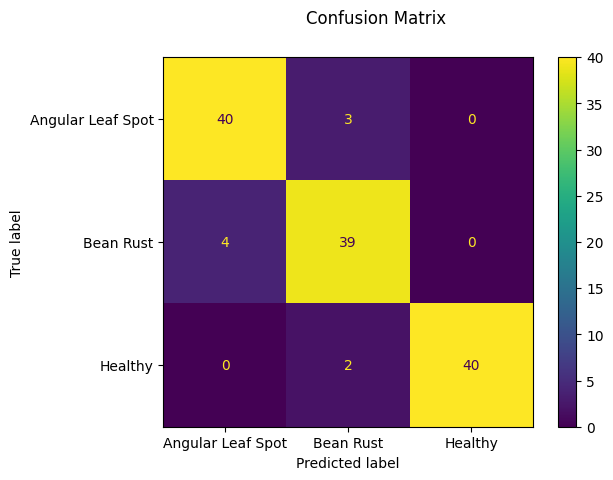

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Make predictions on the test set
predictions = trainer.predict(beans_data["test"])

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids

# Convert logits to predicted class indices
predicted_labels = np.argmax(logits, axis=-1)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Angular Leaf Spot", "Bean Rust", "Healthy"])
disp.plot(cmap="viridis", values_format="d")
disp.figure_.suptitle("Confusion Matrix")

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=["Angular Leaf Spot", "Bean Rust", "Healthy"]))